In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
from skimage import feature
from scipy import ndimage as ndi
import cv2
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from scipy.interpolate import interp2d
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
import warnings
import math
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.interpolate import splev,splrep
from operator import itemgetter 
from math import sqrt
warnings.filterwarnings('ignore')

In [2]:
def extract_tip_to_diameter_ratio(particle, blur = (4,4)):
    """ 
    This function takes an inputted nanorod image (defined in pixels), computes the edge, and determines the locations of the 
    tips on each end of the rod. 
    Parameters
    ----------
    particle : ndarray
        The image of the particle. Must be oriented so the horizontal axis is parallel to the long axis of the rod (if this is 
        and issue let me know and I can include a function that should be able to orient the rods correctly)
    Returns
    -------
    tip length to diameter ratio of the two tips, the length and diameter of the rod, information to reproduce the plots made by 
    this function: 
        list with 5 entries - the first two are the tip length divided by the rod diameter for the two tips, third is the 
        diameter of the rod, fourth is the length of the rod. Last is a list containing all entries necessary to reproduce
        the plot produced by this function showing the rod and the locations of the tips. Within this list, first entry is the
        x values, second are the y values, third is the y value for the horizontal line, fourth is the x value for the start of 
        the horizontal line, fifth is a list containing the location of each of the tip points shown in red on the plot. 
    """
    # uncomment to plot the inputted particle
    # plt.imshow(particle)
    # plt.show()
    
    blurred = cv2.blur(particle, blur) # blurs the particle so the edges can be extracted
    
    # uncomment to plot the particle after blurring if you want to see what the blurring does
    #plt.imshow(blurred)
    #plt.show()
    
    edges = blurred - ndi.morphology.binary_dilation(blurred) # this is how the edge of the particle is extracted 
    pixels = np.argwhere(edges == 255) 
    x = (pixels[:, 1])
    y = (pixels[:, 0])
    
    # uncomment to show the edge of the particle post extraction 
    # plt.imshow(edges, cmap = plt.cm.gray)
    # plt.show()
    
    # uncomment to show the edge of the particle post conversion to a scatter plot. converting the image to a list of x and y 
    # points is how the tips are eventually extracted 
    # plt.scatter(x,y, s=1)
    # plt.show()
    
    # this is a hacked together solution to some problems involving converting pixels to points we can easily interpolate. I 
    # can go into more detail here if it looks like something in here is causing problems, but otherwise best to treat it like 
    # a black box. The issue is a little tricky to explain in words, but if you uncomment the plotting code below and compare to 
    # the scatter plot a couple lines above, it will be obvious what the problem is
    
    #plt.plot(x,y)
    #plt.show()
    
    points = np.vstack((x,y))
    points_t = points.T
    sorted_points = sorted(points_t,key=lambda x: x[0])
    sorted_points.reverse()
        
    new_x = [sorted_points[0][0]]
    new_y = [sorted_points[0][1]]
    temp_x = []
    temp_y = []
    x_val = sorted_points[0][0]
    for i in range(1, len(sorted_points)):
    #if sorted_points[i][0] < x_val:
        #x_val = sorted_points[i][0]
        #new_y.reverse()
        if sorted_points[i][1] == new_y[len(new_y)-1] - 1 or sorted_points[i][1] == new_y[len(new_y)-1]:
            new_x.append(sorted_points[i][0])
            new_y.append(sorted_points[i][1])
        
        elif sorted_points[i][1] < new_y[len(new_y)-1] + 10:
            new_x.append(sorted_points[i][0])
            new_y.append(sorted_points[i][1])
        else: 
            temp_x.append(sorted_points[i][0])
            temp_y.append(sorted_points[i][1])
        
    new_points = np.vstack((new_x, new_y)).T
    new_points_temp = np.vstack((temp_x, temp_y)).T
    flipped = np.flip(new_points_temp)
    flipped_final = np.vstack((flipped.T[1], flipped.T[0])).T
    new_points = np.append(new_points, flipped_final, axis = 0)
    

    # Compare the plot below to the plot at the start of this section to understand what this block has done
    # plt.plot(new_points.T[0], new_points.T[1], color = 'r')
    # plt.show()
    
    # smooth the edge of the particle so the derivatives are reasonably smooth
    # window_size, poly_order = 43, 3
    # interpolated_points = savgol_filter(new_points.T[1], window_size, poly_order)
    # derivs = np.abs(np.gradient(interpolated_points, new_points.T[0])) # calculate dy/dx at each point
    # same plot
    # plt.plot(*new_points.T, color = 'k', linestyle = '-', label='original rod', linewidth = 3);
    # plt.plot(new_points.T[0], interpolated_points, color = 'red', label = 'smoothed rod', linestyle = '-') # plot interpolated points - tip location will eventually be shown on this 
    
    interpolated_points = list(new_points.T[1][0:4])
    for i in range(4, len(new_points.T[1])-4):
        
        start = i-4
        end = i+4
        points_temp = []
        for j in range(start, end+1):
            points_temp.append(new_points.T[1][j])
        new_point = np.mean(points_temp)
        interpolated_points.append(new_point)
    interpolated_points.append(new_points.T[1][len(new_points.T[1])-4])
    interpolated_points.append(new_points.T[1][len(new_points.T[1])-3])
    interpolated_points.append(new_points.T[1][len(new_points.T[1])-2])
    interpolated_points.append(new_points.T[1][len(new_points.T[1])-1])
    derivs = np.abs(np.gradient(interpolated_points, new_points.T[0])) # calculate dy/dx at each point

    plt.plot(*new_points.T/3, color = 'k', linestyle = '-', label='original rod', linewidth = 3);
    plt.ylabel("Nm")
    plt.xlabel("Nm")
    plt.axis('square')
    plt.ylim([0,100])
    plt.legend()
    plt.show()
    plt.plot(*new_points.T/3, color = 'k', linestyle = '-', label='original rod', linewidth = 3);
    plt.plot(new_points.T[0]/3, np.asarray(interpolated_points)/3, color = 'red', label = 'smoothed rod', linestyle = '-') # plot interpolated    
    plt.ylabel("Nm")
    plt.xlabel("Nm")
    plt.axis('square')
    plt.ylim([0,100])
    plt.legend()
    plt.show()
    plt.plot(*new_points.T, color = 'k', linestyle = '-', label='original rod', linewidth = 3);
    plt.plot(new_points.T[0], interpolated_points, color = 'red', label = 'smoothed rod', linestyle = '-') # plot interpolated    
    # different smoothing technique that uses spline interpolation rather than a savgol filter 
    """
    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(new_points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]

    # Interpolation for different methods:
    alpha = np.linspace(0, 1, 50)

    interpolator =  interp1d(distance, new_points, kind='cubic', axis=0)
    interpolated_points = interpolator(alpha)

    # Graph:
    plt.figure(figsize=(7,7))
    plt.plot(interpolated_points.T[0], interpolated_points.T[1], '-', label='smoothed');

    # plt.scatter(*new_points.T, color = 'k', label='original points', s=1);
    plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');
    # interpolated_points = interpolated_points.T[1]
    print(interpolated_points.T[0])
    derivs = np.abs(np.gradient(interpolated_points.T[1], interpolated_points.T[0])) # calculate dy/dx at each point
    interpolated_points = interpolated_points.T[1]
    """
    # code to pick tip locations from smoothed edge 
    
    max_x = max(new_points.T[0])
    min_x = min(new_points.T[0])
    max_y = max(interpolated_points)
    
    tip_points = []
    tip_x_positions = []

    # goes through and finds the 4 points on the rod where a tip is either beginning or ending. These are stored in a list 
    # and returned by the function
    for i in range(0, len(derivs)):
        if derivs[i] < 0.2 and tip_points == []: # first tip point is the bottom right corner of the rod. Find the point where 
            # the derivative of the rod's shape starts to approach zero and add to a list containing the locations that will 
            # build the tips
            if new_points.T[0][i] < max_x: 
                tip_points.append([new_points.T[0][i], interpolated_points[i]])
                tip_x_positions.append(new_points.T[0][i])
        elif derivs[i] > 0.2 and len(tip_points) == 1: # same deal here with the bottom left corner of the rod. Some additional 
            # logic is in place with this and the remaining 2 locations to make sure this location is consistant with the 
            # first location(s) (may eventually want to edit some of this to make it more robust)
            gap_to_tip = max_x - tip_x_positions[0]
            if new_points.T[0][i] < min_x + gap_to_tip:
                tip_points.append([new_points.T[0][i], interpolated_points[i]])
                tip_x_positions.append(new_points.T[0][i])
        elif derivs[i] < 0.2 and len(tip_points) == 2:
            if interpolated_points[i] > max_y * 0.9:
                tip_points.append([new_points.T[0][i], interpolated_points[i]])
                tip_x_positions.append(new_points.T[0][i])
                if tip_x_positions[1] > tip_x_positions[2] + 10 or tip_x_positions[1] < tip_x_positions[2] - 10:
                    tip_points[2][0] = tip_x_positions[1]
        elif derivs[i] > 0.2 and len(tip_points) == 3:
            if new_points.T[0][i] > max_x - gap_to_tip - 10:
                tip_points.append([new_points.T[0][i], interpolated_points[i]])
                tip_x_positions.append(new_points.T[0][i])
                if tip_x_positions[3] > tip_x_positions[0] + 3 or tip_x_positions[3] < tip_x_positions[0] - 3:
                    tip_points[3][0] = tip_x_positions[0]
    

    tip_points = np.asarray(tip_points).T
    

    true_max_x = max(points[0])
    true_min_x = min(points[0])
    avg_y = (max(points[1]) + min(points[1]))/2
    
    
    # plot the locations where tips either begin or end on top of a plot of the outline of the rod
    if tip_points != []:
        pass
        # plt.scatter(tip_points[0], tip_points[1], color = 'r')    
    
    # plt.axis('square')
    # plt.ylim([0,300])
    
    # check if any tips were able to be extracted and if they were, calculate the ratio between the tip length and the 
    # diameter of the rod. This will equal 0.5 for a perfectly spherical rod. 
    
    if tip_points != []:
        if len(tip_points[0]) == 4:
            plt.plot(tip_points[0][1:3], tip_points[1][1:3], label = "rod diameter", color = 'b')
            plt.plot([true_min_x,tip_points[0][1]], [avg_y, avg_y], 'green', label = "tip length", linestyle = '--')
            b = [0,3]
            plt.plot(itemgetter(*b)(tip_points[0]), itemgetter(*b)(tip_points[1]), color = 'b')
            plt.plot([true_max_x,tip_points[0][0]], [avg_y, avg_y], 'green', linestyle = '--')
            plt.legend()
            plt.axis('square')
            plt.ylim([0,300])
            plt.show()
            
            rod_dia1 = tip_points[1][3] - tip_points[1][0]
            rod_tip_length1 = true_max_x - (tip_points[0][0] + tip_points[0][3])/2

            rod_dia2 = tip_points[1][2] - tip_points[1][1]
            rod_tip_length2 = (tip_points[0][1] + tip_points[0][2])/2 - true_min_x

            tip_to_dia_ratio_1 = rod_tip_length1/rod_dia1
            tip_to_dia_ratio_2 = rod_tip_length2/rod_dia2
            avg_rod_dia = (rod_dia1 + rod_dia2)/2
            rod_length = max_x - min_x
            
            
            return [tip_to_dia_ratio_1, tip_to_dia_ratio_2, avg_rod_dia, rod_length, [new_points.T[0], interpolated_points, 
                                                                                     avg_y, true_min_x, tip_points]]
    else: 
        print("no tips extracted - make sure the long axis is parallel to the horizontal axis or that the image is a nanorod")
    



In [3]:
path = 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/longrods.mat' # replace with wherever you save the file
data = loadmat(path)

1


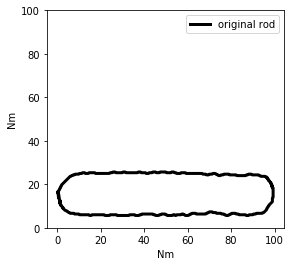

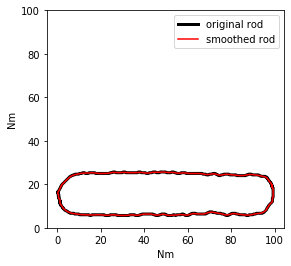

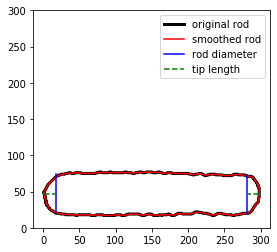

[0.3248407643312102, 0.3006263048016702, 52.77777777777777, 297]
2


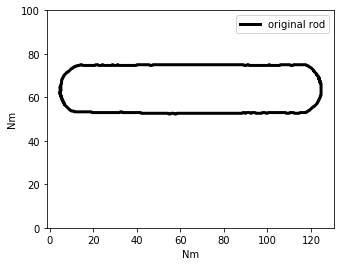

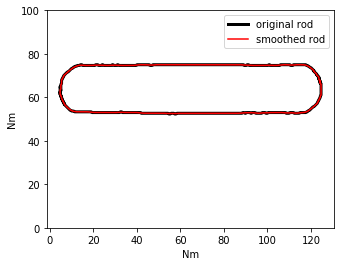

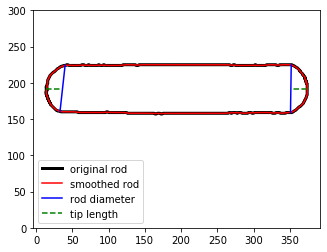

[0.3443877551020409, 0.3546409807355516, 64.38888888888889, 360]
3


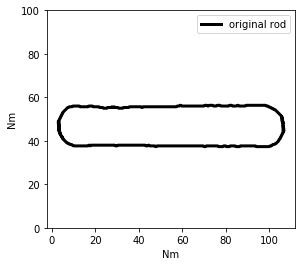

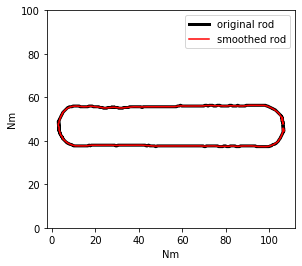

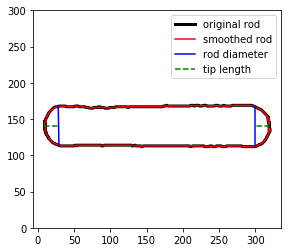

[0.37425742574257415, 0.36410788381742726, 54.83333333333335, 311]
5


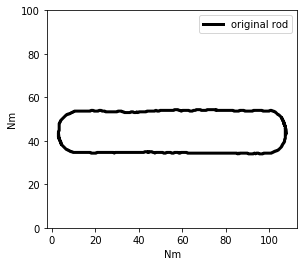

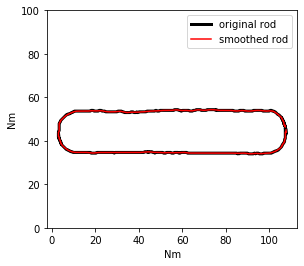

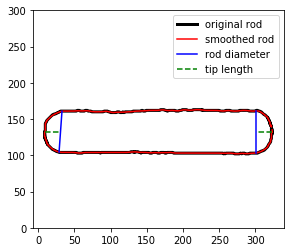

[0.3815028901734105, 0.39130434782608703, 56.944444444444436, 314]
6


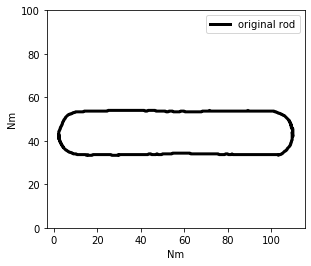

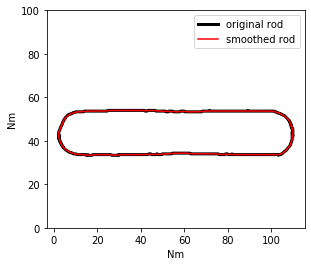

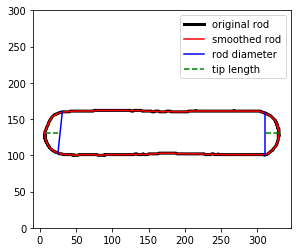

[0.32022471910112354, 0.3720472440944883, 57.888888888888886, 323]
7


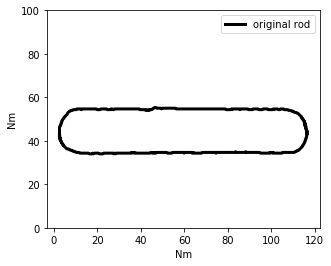

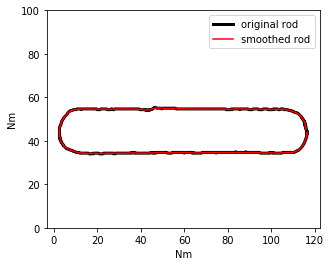

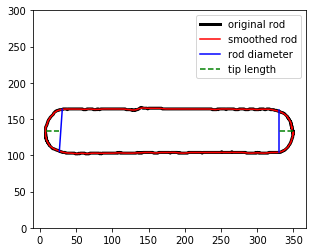

[0.34090909090909094, 0.36416184971098253, 58.16666666666667, 342]
9


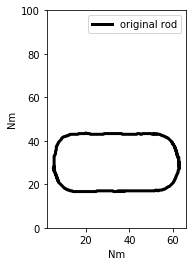

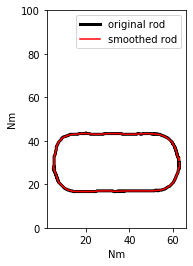

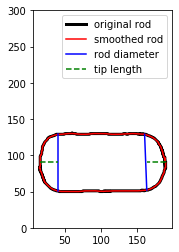

[0.35817655571635315, 0.3209700427960057, 77.33333333333333, 174]
10


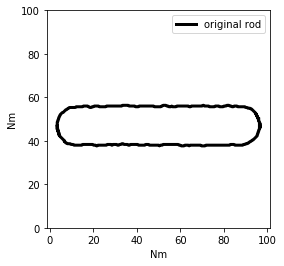

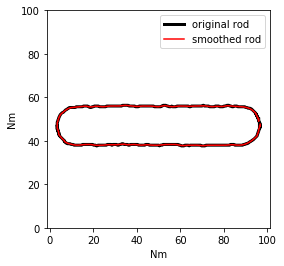

KeyboardInterrupt: 

In [4]:
to_skip = [124, 114, 108, 104, 100, 75, 44, 41, 36, 32, 8, 4]

tip_to_diameter_ratios = []
rod_diameters = []
rod_lengths = []
for i in range(1,300):
    if i not in to_skip:
        print(i)
        image = data['particles_plot'][0][i]
        rotated = ndimage.rotate(image, 360-data['orientation_plot'][0][i][0][0])
        ratio_extracted = extract_tip_to_diameter_ratio(rotated)
        #avg_ratio = (ratio_extracted[0] + ratio_extracted[1])/2
        #tip_to_diameter_ratios.append(avg_ratio)
        #rod_diameters.append(ratio_extracted[2])
        #rod_lengths.append(ratio_extracted[3])
        print(ratio_extracted[0:4])


#print(np.mean(tip_to_diameter_ratios))
#print(np.std(tip_to_diameter_ratios))

In [5]:
ratio_extracted[4]
# plt.plot(ratio_extracted[4][0], ratio_extracted[4][1])
xs = np.asarray(ratio_extracted[4][0])/3
ys = np.asarray(ratio_extracted[4][1])/3

In [6]:
def findCircle(x1, y1, x2, y2, x3, y3) : 
    x12 = x1 - x2;  
    x13 = x1 - x3;  
  
    y12 = y1 - y2;  
    y13 = y1 - y3;  
  
    y31 = y3 - y1;  
    y21 = y2 - y1;  
  
    x31 = x3 - x1;  
    x21 = x2 - x1;  
  
    # x1^2 - x3^2  
    sx13 = pow(x1, 2) - pow(x3, 2);  
  
    # y1^2 - y3^2  
    sy13 = pow(y1, 2) - pow(y3, 2);  
  
    sx21 = pow(x2, 2) - pow(x1, 2);  
    sy21 = pow(y2, 2) - pow(y1, 2);  
  
    f = (((sx13) * (x12) + (sy13) * 
          (x12) + (sx21) * (x13) + 
          (sy21) * (x13)) // (2 * 
          ((y31) * (x12) - (y21) * (x13)))); 
              
    g = (((sx13) * (y12) + (sy13) * (y12) + 
          (sx21) * (y13) + (sy21) * (y13)) // 
          (2 * ((x31) * (y12) - (x21) * (y13))));  
  
    c = (-pow(x1, 2) - pow(y1, 2) - 
         2 * g * x1 - 2 * f * y1);  
  
    # eqn of circle be x^2 + y^2 + 2*g*x + 2*f*y + c = 0  
    # where centre is (h = -g, k = -f) and  
    # radius r as r^2 = h^2 + k^2 - c  
    h = -g;  
    k = -f;  
    sqr_of_r = h * h + k * k - c;  
  
    # r is the radius  
    r = round(sqrt(sqr_of_r), 5);  
    # print(type(r))
    # print("Centre = (", h, ", ", k, ")");  
    curvature = round(1/r, 4)
    if np.isnan(curvature) == True:
        curvature = 0
    return curvature 

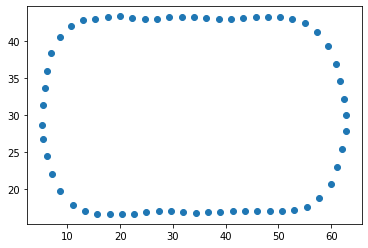

In [7]:
points = np.arange(1, len(xs)-4, 7)
new_xs = []
new_ys = []
for i in points:
    start = i-3
    end = i+3
    points_temp_x = []
    points_temp_y = []
    for j in range(start, end+1):
        points_temp_x.append(xs[j])
        points_temp_y.append(ys[j])
    new_point_x = np.mean(points_temp_x)
    new_point_y = np.mean(points_temp_y)
    new_xs.append(new_point_x)
    new_ys.append(new_point_y)
plt.scatter(new_xs, new_ys)

In [8]:
curvatures = []
curvatures.append(findCircle(new_xs[len(new_ys)-1], new_ys[len(new_ys)-1], new_xs[0], new_ys[0], new_xs[1], new_ys[1]))
for i in range(1, len(new_xs)-1): 
    points = [i-1, i, i+1]
    circle_xs = []
    circle_ys = []
    for point in points: 
        x = new_xs[point]
        y = new_ys[point]
        circle_xs.append(x)
        circle_ys.append(y)
    curvatures.append(findCircle(circle_xs[0], circle_ys[0],circle_xs[1], circle_ys[1],circle_xs[2], circle_ys[2]))
curvatures.append(findCircle(new_xs[len(new_ys)-2], new_ys[len(new_ys)-2], new_xs[len(new_ys)-1], new_ys[len(new_ys)-1], new_xs[0], new_ys[0]))


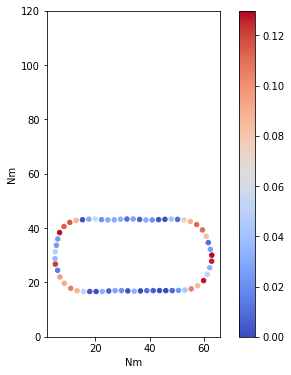

In [9]:
# plt.xlim([0,140])
# plt.ylim([0,140])
plt.figure(figsize = (7.0, 6.0))
sc = plt.scatter(new_xs, new_ys, c=curvatures, cmap = 'coolwarm', s = 20)
plt.ylabel("Nm")
plt.xlabel("Nm")
plt.axis('square')
plt.ylim([0,120])
plt.colorbar(sc)
plt.show()

In [10]:
# plt.xlim([0,140])
# plt.ylim([0,140])
plt.figure(figsize = (7.0, 6.0))
sc = plt.scatter(new_xs, new_ys, c=new_curvatures, cmap = 'coolwarm', s = 20)
plt.ylabel("Nm")
plt.xlabel("Nm")
plt.axis('square')
plt.ylim([0,120])
plt.colorbar(sc)
plt.show()

NameError: name 'new_curvatures' is not defined

<Figure size 504x432 with 0 Axes>

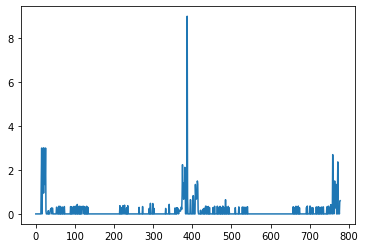

In [273]:
plt.plot(curvatures)

In [274]:
np.arange(0,15,3)

array([ 0,  3,  6,  9, 12])

In [275]:
points = np.arange(1, len(curvatures)-5, 9)
new_curvatures = []
new_xs = []
new_ys = []
for i in points:
        
        start = i-4
        end = i+4
        points_temp = []
        for j in range(start, end+1):
            points_temp.append(curvatures[j])
        new_point = np.mean(points_temp)
        new_curvatures.append(new_point)
        new_xs.append(xs[i])
        new_ys.append(ys[i])


In [223]:
# curvature analysis - fit a circle to three points starting at the location of the tip. The reciprocal of the radius of this
# circle is the mathematical definition of the curvature at the center of the three points

In [ ]:
# Define some points:
points = np.array([[0, 1, 8, 2, 2],
                   [1, 0, 6, 7, 2]]).T  # a (nbre_points x nbre_dim) array

# Linear length along the line:
distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
distance = np.insert(distance, 0, 0)/distance[-1]

# Interpolation for different methods:
interpolations_methods = ['slinear', 'quadratic', 'cubic']
alpha = np.linspace(0, 1, 75)

interpolated_points = {}
for method in interpolations_methods:
    interpolator =  interp1d(distance, points, kind=method, axis=0)
    interpolated_points[method] = interpolator(alpha)

# Graph:
plt.figure(figsize=(7,7))
for method_name, curve in interpolated_points.items():
    plt.plot(*curve.T, '-', label=method_name);

plt.plot(*points.T, 'ok', label='original points');
plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');

Text(0.5, 1.0, 'Curvature vs Length')

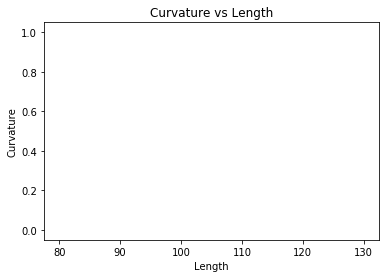

In [207]:
x = np.linspace(0,1,10)
y = np.linspace(80,130,10)
plt.plot(y,x,color = 'white')
plt.xlabel("Length")
plt.ylabel("Curvature")
plt.title("Curvature vs Length")

Text(0.5, 1.0, 'Curvature vs Diameter')

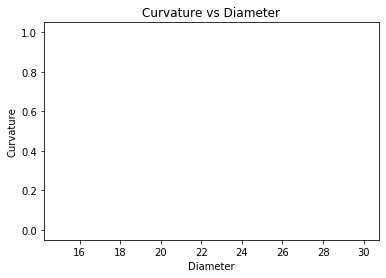

In [208]:
x = np.linspace(0,1,10)
y = np.linspace(15,30,10)
plt.plot(y,x,color = 'white')
plt.xlabel("Diameter")
plt.ylabel("Curvature")
plt.title("Curvature vs Diameter")

Text(0.5, 1.0, 'Curvature vs Aspect Ratio')

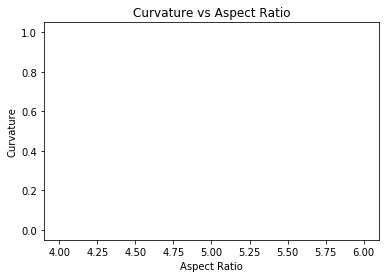

In [209]:
x = np.linspace(0,1,10)
y = np.linspace(4,6,10)
plt.plot(y,x,color = 'white')
plt.xlabel("Aspect Ratio")
plt.ylabel("Curvature")
plt.title("Curvature vs Aspect Ratio")

In [292]:
def determine_curvature(particle, blur=(4,4)): 
    """ 
    This function takes an inputted nanorod image (defined in pixels), computes the edge, and determines the locations of the 
    tips on each end of the rod. 
    Parameters
    ----------
    particle : ndarray
        The image of the particle. Must be oriented so the horizontal axis is parallel to the long axis of the rod (if this is 
        and issue let me know and I can include a function that should be able to orient the rods correctly)
    Returns
    -------
    tip length to diameter ratio of the two tips, the length and diameter of the rod, information to reproduce the plots made by 
    this function: 
        list with 5 entries - the first two are the tip length divided by the rod diameter for the two tips, third is the 
        diameter of the rod, fourth is the length of the rod. Last is a list containing all entries necessary to reproduce
        the plot produced by this function showing the rod and the locations of the tips. Within this list, first entry is the
        x values, second are the y values, third is the y value for the horizontal line, fourth is the x value for the start of 
        the horizontal line, fifth is a list containing the location of each of the tip points shown in red on the plot. 
    """
    # uncomment to plot the inputted particle
    # plt.imshow(particle)
    # plt.show()
    
    blurred = cv2.blur(particle, blur) # blurs the particle so the edges can be extracted
    
    # uncomment to plot the particle after blurring if you want to see what the blurring does
    #plt.imshow(blurred)
    #plt.show()
    
    edges = blurred - ndi.morphology.binary_dilation(blurred) # this is how the edge of the particle is extracted 
    pixels = np.argwhere(edges == 255) 
    x = (pixels[:, 1])
    y = (pixels[:, 0])
    
    # uncomment to show the edge of the particle post extraction 
    # plt.imshow(edges, cmap = plt.cm.gray)
    # plt.show()
    
    # uncomment to show the edge of the particle post conversion to a scatter plot. converting the image to a list of x and y 
    # points is how the tips are eventually extracted 
    # plt.scatter(x,y, s=1)
    # plt.show()
    
    # this is a hacked together solution to some problems involving converting pixels to points we can easily interpolate. I 
    # can go into more detail here if it looks like something in here is causing problems, but otherwise best to treat it like 
    # a black box. The issue is a little tricky to explain in words, but if you uncomment the plotting code below and compare to 
    # the scatter plot a couple lines above, it will be obvious what the problem is
    
    #plt.plot(x,y)
    #plt.show()
    
    points = np.vstack((x,y))
    points_t = points.T
    sorted_points = sorted(points_t,key=lambda x: x[0])
    sorted_points.reverse()
        
    new_x = [sorted_points[0][0]]
    new_y = [sorted_points[0][1]]
    temp_x = []
    temp_y = []
    x_val = sorted_points[0][0]
    for i in range(1, len(sorted_points)):
    #if sorted_points[i][0] < x_val:
        #x_val = sorted_points[i][0]
        #new_y.reverse()
        if sorted_points[i][1] == new_y[len(new_y)-1] - 1 or sorted_points[i][1] == new_y[len(new_y)-1]:
            new_x.append(sorted_points[i][0])
            new_y.append(sorted_points[i][1])
        
        elif sorted_points[i][1] < new_y[len(new_y)-1] + 10:
            new_x.append(sorted_points[i][0])
            new_y.append(sorted_points[i][1])
        else: 
            temp_x.append(sorted_points[i][0])
            temp_y.append(sorted_points[i][1])
        
    new_points = np.vstack((new_x, new_y)).T
    new_points_temp = np.vstack((temp_x, temp_y)).T
    flipped = np.flip(new_points_temp)
    flipped_final = np.vstack((flipped.T[1], flipped.T[0])).T
    new_points = np.append(new_points, flipped_final, axis = 0)
    

    # Compare the plot below to the plot at the start of this section to understand what this block has done
    # plt.plot(new_points.T[0], new_points.T[1], color = 'r')
    # plt.show()
    
    # smooth the edge of the particle so the derivatives are reasonably smooth
    # window_size, poly_order = 43, 3
    # interpolated_points = savgol_filter(new_points.T[1], window_size, poly_order)
    # derivs = np.abs(np.gradient(interpolated_points, new_points.T[0])) # calculate dy/dx at each point
    # same plot
    # plt.plot(*new_points.T, color = 'k', linestyle = '-', label='original rod', linewidth = 3);
    # plt.plot(new_points.T[0], interpolated_points, color = 'red', label = 'smoothed rod', linestyle = '-') # plot interpolated points - tip location will eventually be shown on this 
    """
    interpolated_points = list(new_points.T[1][0:4])
    for i in range(4, len(new_points.T[1])-4):
        
        start = i
        end = i
        points_temp = []
        for j in range(start, end+1):
            points_temp.append(new_points.T[1][j])
        new_point = np.mean(points_temp)
        interpolated_points.append(new_point)
    interpolated_points.append(new_points.T[1][len(new_points.T[1])-4])
    interpolated_points.append(new_points.T[1][len(new_points.T[1])-3])
    interpolated_points.append(new_points.T[1][len(new_points.T[1])-2])
    interpolated_points.append(new_points.T[1][len(new_points.T[1])-1])
    derivs = np.abs(np.gradient(interpolated_points, new_points.T[0])) # calculate dy/dx at each point
    """
    
    """
    plt.plot(*new_points.T/3, color = 'k', linestyle = '-', label='original rod', linewidth = 3);
    plt.ylabel("Nm")
    plt.xlabel("Nm")
    plt.axis('square')
    plt.ylim([0,100])
    plt.legend()
    plt.show()
    plt.plot(*new_points.T/3, color = 'k', linestyle = '-', label='original rod', linewidth = 3);
    plt.plot(new_points.T[0]/3, np.asarray(interpolated_points)/3, color = 'red', label = 'smoothed rod', linestyle = '-') # plot interpolated    
    plt.ylabel("Nm")
    plt.xlabel("Nm")
    plt.axis('square')
    plt.ylim([0,100])
    plt.legend()
    plt.show()
    plt.plot(*new_points.T, color = 'k', linestyle = '-', label='original rod', linewidth = 3);
    # plt.plot(new_points.T[0], interpolated_points, color = 'red', label = 'smoothed rod', linestyle = '-') # plot interpolated    
    # different smoothing technique that uses spline interpolation rather than a savgol filter 
    """
    
    """
    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(new_points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]

    # Interpolation for different methods:
    alpha = np.linspace(0, 1, 50)

    interpolator =  interp1d(distance, new_points, kind='cubic', axis=0)
    interpolated_points = interpolator(alpha)

    # Graph:
    plt.figure(figsize=(7,7))
    plt.plot(interpolated_points.T[0], interpolated_points.T[1], '-', label='smoothed');

    # plt.scatter(*new_points.T, color = 'k', label='original points', s=1);
    plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');
    # interpolated_points = interpolated_points.T[1]
    print(interpolated_points.T[0])
    derivs = np.abs(np.gradient(interpolated_points.T[1], interpolated_points.T[0])) # calculate dy/dx at each point
    interpolated_points = interpolated_points.T[1]
    """
    # code to pick tip locations from smoothed edge 
    
    # max_x = max(new_points.T[0])
    # min_x = min(new_points.T[0])
    # max_y = max(interpolated_points)
    
    tip_points = []
    tip_x_positions = []
    
    points = np.arange(0, len(new_points.T[0]), 1)
    new_xs = []
    new_ys = []
    for i in points:
        start = i-3
        end = i+3
        points_temp_x = []
        points_temp_y = []
        if start >= 0 and end <= len(new_points.T[0]) - 3:
            for j in range(start, end+1):
                points_temp_x.append(new_points.T[0][j])
                points_temp_y.append(new_points.T[1][j])
        if start < 0:
            points_list = []
            new_start = len(new_points.T[0]) + start 
            for k in range(new_start, len(new_points.T[0])):
                points_list.append(k)
            for k in range(0, end):
                points_list.append(k)
            for j in points_list:
                points_temp_x.append(new_points.T[0][j])
                points_temp_y.append(new_points.T[1][j])
        if end > len(new_points.T[0]) - 3:
            points_list = []
            new_end = end - (len(new_points.T[0]) - 3)
            for k in range(start, len(new_points.T[0])):
                points_list.append(k)
            for k in range(0, new_end):
                points_list.append(k)
            for j in points_list:
                points_temp_x.append(new_points.T[0][j])
                points_temp_y.append(new_points.T[1][j])
        new_point_x = np.mean(points_temp_x)
        new_point_y = np.mean(points_temp_y)
        new_xs.append(new_point_x)
        new_ys.append(new_point_y)
    # plt.plot(*new_points.T, color = 'k', linestyle = '-', label='original rod', linewidth = 3);
    # plt.plot(new_xs, new_ys, 'r')
    # plt.show()
    
    new_xs = np.asarray(new_xs)/3
    new_ys = np.asarray(new_ys)/3

    
    
    curvature_points = np.arange(3, len(new_xs)-3, 7)
    new_xs_curvature = []
    new_ys_curvature = []
    for i in curvature_points:
        start = i-3
        end = i+3
        points_temp_x = []
        points_temp_y = []
        for j in range(start, end+1):
            points_temp_x.append(new_xs[j])
            points_temp_y.append(new_ys[j])
        new_point_x = np.mean(points_temp_x)
        new_point_y = np.mean(points_temp_y)
        new_xs_curvature.append(new_point_x)
        new_ys_curvature.append(new_point_y)
    
    
    
    curvatures = []
    curvatures.append(findCircle(new_xs_curvature[len(new_ys_curvature)-3], new_ys_curvature[len(new_ys_curvature)-3], 
                                 new_xs_curvature[len(new_ys_curvature)-1], new_ys_curvature[len(new_ys_curvature)-1], 
                                 new_xs_curvature[1], new_ys_curvature[1]))
    curvatures.append(findCircle(new_xs_curvature[len(new_ys_curvature)-2], new_ys_curvature[len(new_ys_curvature)-2], 
                                 new_xs_curvature[0], new_ys_curvature[0], new_xs_curvature[2], new_ys_curvature[2]))
    for i in range(2, len(new_xs_curvature)-2): 
        points = [i-2, i, i+2]
        circle_xs = []
        circle_ys = []
        for point in points: 
            x = new_xs_curvature[point]
            y = new_ys_curvature[point]
            circle_xs.append(x)
            circle_ys.append(y)
        curvatures.append(findCircle(circle_xs[0], circle_ys[0],circle_xs[1], circle_ys[1],circle_xs[2], circle_ys[2]))
        
    curvatures.append(findCircle(new_xs_curvature[len(new_xs_curvature)-5], new_ys_curvature[len(new_ys_curvature)-4], 
                                 new_xs_curvature[len(new_xs_curvature)-3], new_ys_curvature[len(new_ys_curvature)-3],
                                 new_xs_curvature[len(new_xs_curvature)-1], new_ys_curvature[len(new_xs_curvature)-1]))
    
    curvatures.append(findCircle(new_xs_curvature[len(new_xs_curvature)-4], new_ys_curvature[len(new_ys_curvature)-4], 
                                 new_xs_curvature[len(new_xs_curvature)-2], new_ys_curvature[len(new_ys_curvature)-2],
                                 new_xs_curvature[0], new_ys_curvature[0]))
    
    # plt.xlim([0,140])
    # plt.ylim([0,140])

    derivs = np.abs(np.gradient(new_ys, new_xs)) # calculate dy/dx at each point
    min_x = min(new_xs)
    max_x = max(new_xs)
    
    max_x_index = list(new_xs).index(max_x)
    min_x_index = list(new_xs).index(min_x)
    
    for i in range(max_x_index, len(derivs)):
        # print(derivs[i], new_xs[i], new_ys[i])
        if derivs[i] < 0.2 and tip_points == []: # first tip point is the bottom right corner of the rod. Find the point where 
            # the derivative of the rod's shape starts to approach zero and add to a list containing the locations that will 
            # build the tips
            if derivs[i+1]/10 < derivs[i]:
                tip_points.append([new_xs[i], new_ys[i]])

                # if new_xs[i] > 0.8*max_x:
                    # curvatures_region = [curvatures[i-1], curvatures[i], curvatures[i+1]]
                    # max_curve = max(curvatures_region)
                    # index_curve = curvatures_region.index(max_curve)
                    # tip_points.append([new_xs[i], new_ys[i]])
                    # right_tip_end = i
                """
                    if index_curve == 0: 
                        tip_points.append([new_xs[i-1], new_ys[i-1]])
                        right_tip_end = i-1
                    if index_curve == 1: 
                        tip_points.append([new_xs[i], new_ys[i]])
                        right_tip_end = i
                    if index_curve == 2: 
                        tip_points.append([new_xs[i+1], new_ys[i+1]])
                        right_tip_end = i+1
                """
    # print(np.linspace(max_x_index, -len(derivs), (max_x_index + len(derivs) + 1)))
    for i in np.linspace(max_x_index, -len(derivs), (max_x_index + len(derivs) + 1)):  
        i = int(i)
        if i < 0:
            i = len(derivs) + i
        # print([new_xs[i], new_ys[i]])
        if derivs[i] < 0.2 and len(tip_points) == 1: # same deal here with the bottom left corner of the rod. Some additional 
            # logic is in place with this and the remaining 2 locations to make sure this location is consistant with the 
            # first location(s) (may eventually want to edit some of this to make it more robust)
            if i != 0:
                tip_points.append([new_xs[i], new_ys[i]])

                # if new_xs[i] > 0.8*max_x:
                    # curvatures_region = [curvatures[i-1], curvatures[i], curvatures[i+1]]
                    # max_curve = max(curvatures_region)
                    # index_curve = curvatures_region.index(max_curve)
                    # tip_points.append([new_xs[i], new_ys[i]])
                    # right_tip_end = i
                """
                    if index_curve == 0: 
                        tip_points.append([new_xs[i-1], new_ys[i-1]])
                        right_tip_end = i-1
                    if index_curve == 1: 
                        tip_points.append([new_xs[i], new_ys[i]])
                        right_tip_end = i
                    if index_curve == 2: 
                        tip_points.append([new_xs[i+1], new_ys[i+1]])
                        right_tip_end = i+1
                """


    for i in np.linspace(min_x_index, len(derivs)-1, (len(derivs) - min_x_index)):  
        i = int(i)
        # print(i)
        # print([new_xs[i], new_ys[i]])
        if derivs[i] < 0.2 and len(tip_points) == 2: # same deal here with the bottom left corner of the rod. Some additional 
            # logic is in place with this and the remaining 2 locations to make sure this location is consistant with the 
            # first location(s) (may eventually want to edit some of this to make it more robust)
            if i != 0:
                tip_points.append([new_xs[i], new_ys[i]])

                # if new_xs[i] < 1.2*min_x:
                # curvatures_region = [curvatures[i-1], curvatures[i], curvatures[i+1]]
                # max_curve = max(curvatures_region)
                # index_curve = curvatures_region.index(max_curve)
                # tip_points.append([new_xs[i], new_ys[i]])
                # right_tip_end = i
                """
                if index_curve == 0: 
                    tip_points.append([new_xs[i-1], new_ys[i-1]])
                    right_tip_end = i-1
                if index_curve == 1: 
                    tip_points.append([new_xs[i], new_ys[i]])
                    right_tip_end = i
                if index_curve == 2: 
                    tip_points.append([new_xs[i+1], new_ys[i+1]])
                    right_tip_end = i+1
                """
                    

                    
    for i in np.linspace(min_x_index, 0, (min_x_index + 1)):  
        i = int(i)
        # print(i)
        # print([new_xs[i], new_ys[i]])
        if derivs[i] < 0.2 and len(tip_points) == 3: # same deal here with the bottom left corner of the rod. Some additional 
            # logic is in place with this and the remaining 2 locations to make sure this location is consistant with the 
            # first location(s) (may eventually want to edit some of this to make it more robust)
            if i != 0:
                tip_points.append([new_xs[i], new_ys[i]])

                # if new_xs[i] < 1.2*min_x:
                # curvatures_region = [curvatures[i-1], curvatures[i], curvatures[i+1]]
                # max_curve = max(curvatures_region)
                # index_curve = curvatures_region.index(max_curve)
                # tip_points.append([new_xs[i], new_ys[i]])
                # right_tip_end = i
                """
                if index_curve == 0: 
                    tip_points.append([new_xs[i-1], new_ys[i-1]])
                    right_tip_end = i-1
                if index_curve == 1: 
                    tip_points.append([new_xs[i], new_ys[i]])
                    right_tip_end = i
                if index_curve == 2: 
                    tip_points.append([new_xs[i+1], new_ys[i+1]])
                    right_tip_end = i+1
                """
                                        
                    

                    



    """
    left_tip_curvatures = []
    for i in range(left_tip_begining, left_tip_end + 1):
        left_tip_curvatures.append(curvatures[i])
    avg_curvature_left = np.mean(left_tip_curvatures)
    
    right_tip_curvatures = []
    for i in range(right_tip_begining, len(curvatures)):
        right_tip_curvatures.append(curvatures[i])
    for i in range(0, right_tip_end + 1):
        right_tip_curvatures.append(curvatures[i])
    avg_curvature_right = np.mean(right_tip_curvatures)
    """
    true_min_x = min(new_xs)
    true_max_x = max(new_xs)
    
    min_y = min(new_ys)
    max_y = max(new_ys)
    # print(tip_points)
    avg_y = (min(new_ys) + max(new_ys))/2
    plt.plot(new_points.T[0]/3, new_points.T[1]/3, 'k', linewidth = 3, label = 'original rod')
    plt.plot(new_xs, new_ys, 'orange', label = 'smoothed rod')
    plt.ylim([0,100])
    # sc = plt.scatter(new_xs, new_ys, c=curvatures, cmap = 'coolwarm', s = 20)
    # plt.colorbar(sc)
    if tip_points != []:
        if len(tip_points) == 4:
            plt.plot([tip_points[0][0],tip_points[1][0]], [tip_points[0][1],tip_points[1][1]], label = "rod diameter", color = 'b')
            plt.plot([true_max_x,np.mean([tip_points[0][0],tip_points[1][0]])], [avg_y, avg_y], 'green', label = "tip length", linestyle = '--')
            # b = [0,3]
            plt.plot([tip_points[2][0],tip_points[3][0]], [tip_points[2][1],tip_points[3][1]], color = 'b')
            plt.plot([true_min_x,np.mean([tip_points[3][0],tip_points[2][0]])], [avg_y, avg_y], 'green', linestyle = '--')
            plt.legend()
            # plt.axis('square')
            # plt.ylim([0,100])
            plt.show()
           
            rod_dia1 = tip_points[1][1] - tip_points[0][1]
            rod_tip_length1 = true_max_x - (tip_points[0][0] + tip_points[1][0])/2

            rod_dia2 = tip_points[2][1] - tip_points[3][1]
            rod_tip_length2 = (tip_points[3][0] + tip_points[2][0])/2 - true_min_x

            tip_to_dia_ratio_1 = rod_tip_length1/rod_dia1
            tip_to_dia_ratio_2 = rod_tip_length2/rod_dia2
            avg_rod_dia = (rod_dia1 + rod_dia2)/2
            rod_length = max_x - min_x
            
            print(tip_to_dia_ratio_1, tip_to_dia_ratio_2)
            # print(avg_curvature_left, avg_curvature_right)
            
            tip_area_1 = np.pi*rod_tip_length1*rod_dia1/2
            tip_area_2 = np.pi*rod_tip_length2*rod_dia2/2
            tip_area = tip_area_1 + tip_area_2
            rod_rectangle_area = (max_y - min_y)*((max_x - min_x) - (rod_tip_length1 + rod_tip_length2))
            print(rod_rectangle_area+tip_area, tip_area, tip_area/(rod_rectangle_area+tip_area))
    
    sc = plt.scatter(new_xs_curvature, new_ys_curvature, c=curvatures, cmap = 'coolwarm', s = 20)
    plt.colorbar(sc)
    # plt.plot(new_xs, new_ys)
    plt.plot([tip_points[0][0],tip_points[1][0]], [tip_points[0][1],tip_points[1][1]], label = "rod diameter", color = 'b')
    plt.plot([true_max_x,np.mean([tip_points[0][0],tip_points[1][0]])], [avg_y, avg_y], 'green', label = "tip length", linestyle = '--')
    plt.plot([tip_points[2][0],tip_points[3][0]], [tip_points[2][1],tip_points[3][1]], color = 'b')
    plt.plot([true_min_x,np.mean([tip_points[3][0],tip_points[2][0]])], [avg_y, avg_y], 'green', linestyle = '--')
    plt.legend()
    # plt.axis('square')
    plt.ylim([0,100])
    plt.show()
    avg_curvature_right = []
    avg_curvature_left = []
    for i in range(0, len(new_xs_curvature)):
        if new_xs_curvature[i] > np.mean([tip_points[0][0],tip_points[1][0]]):
            avg_curvature_right.append(curvatures[i])
        if new_xs_curvature[i] < np.mean([tip_points[2][0],tip_points[3][0]]):
            avg_curvature_left.append(curvatures[i])
    avg_curvature_right = np.mean(avg_curvature_right)
    avg_curvature_left = np.mean(avg_curvature_left)
    print(avg_curvature_right, avg_curvature_left)

In [290]:
# new idea to pick tips - start at the maximum x value and go down the tip in each direction until the end is found. This
# seems to have worked well! 

0


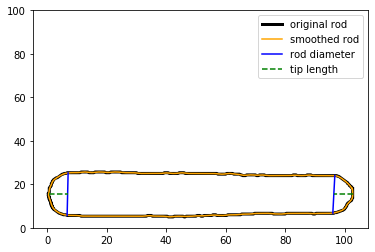

0.3684210526315787 0.3296568627450981
2211.884723962812 366.47996205805 0.16568673678502766


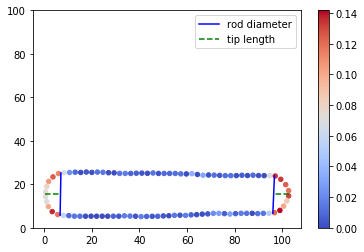

0.12140000000000001 0.09956
1


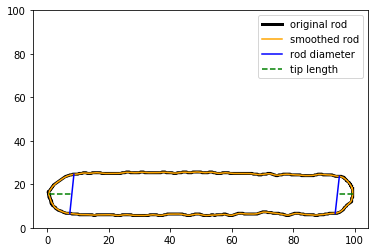

0.2957746478873231 0.4153439153439154
2070.82066188492 344.1539952182529 0.16619208102018554


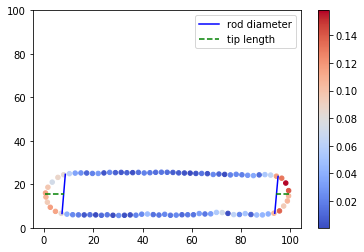

0.12502857142857143 0.09887777777777779
2


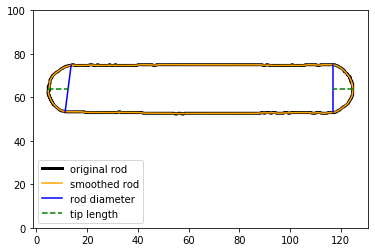

0.3500000000000002 0.36718749999999994
2875.0534740632806 526.2915693013761 0.1830545323936442


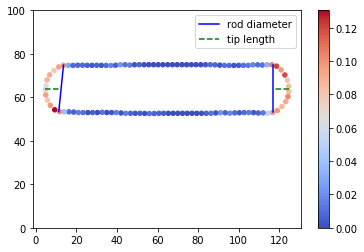

0.09749000000000001 0.09103636363636364
3


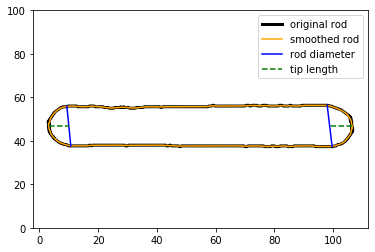

0.4105485232067506 0.38157894736842124
2112.254071011757 424.4207376784235 0.20093261672594553


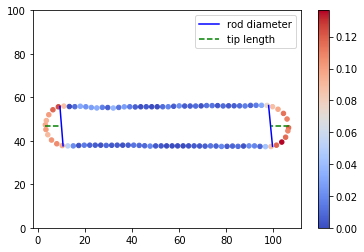

0.10927000000000002 0.1043
4


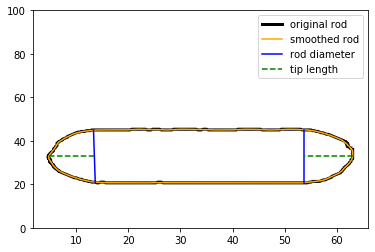

0.3828125000000001 0.36481113320079517
1676.9860302672423 686.2082524894645 0.4091913946236697


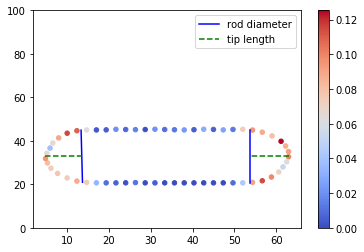

0.08917692307692306 0.08131666666666668
5


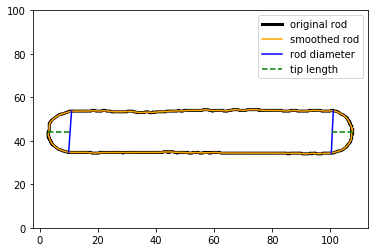

0.36029411764705965 0.3977272727272728
2269.1726698368448 435.78378094795596 0.1920452272057768


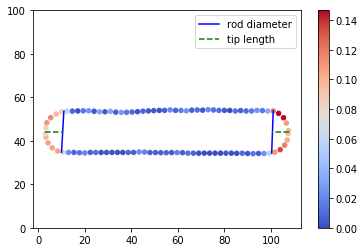

0.11807999999999999 0.09867000000000001
6


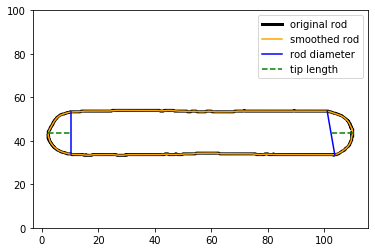

0.38516746411483194 0.41277641277641264
2384.5900699355348 483.25673660220116 0.20265820221891034


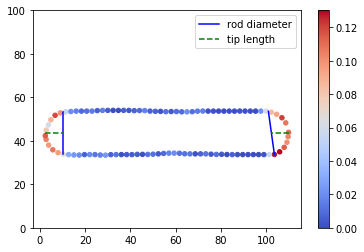

0.11238888888888887 0.09401818181818182
7


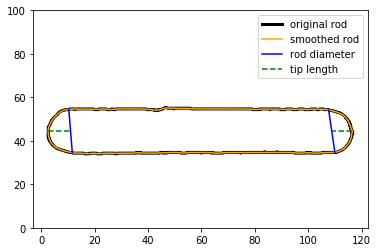

0.39486552567237077 0.41766109785202876
2560.269242254382 496.45178193692135 0.193906083681958


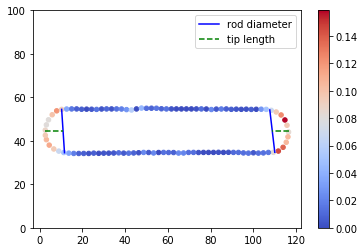

0.11353000000000002 0.09465454545454545
8


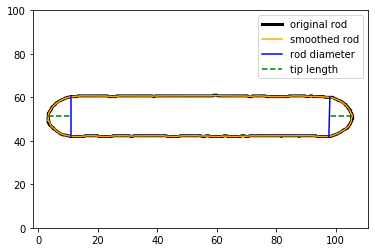

0.4283819628647206 0.4225721784776902
2072.7867057528265 435.3581343242546 0.21003518264371276


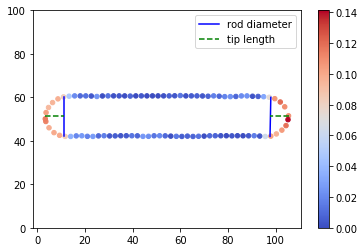

0.1124 0.10177777777777779
9


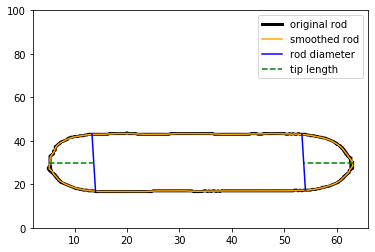

0.36296296296296277 0.3242258652094718
1793.638190192795 725.0667616213666 0.40424360140515875


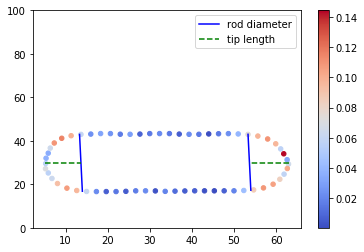

0.08852307692307693 0.07597142857142859
10


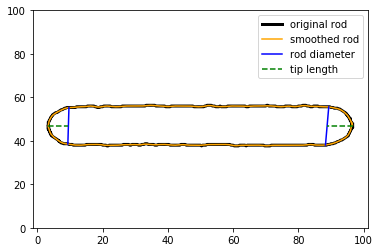

0.4455040871934599 0.3678977272727273
1853.2064125890768 376.0953014779657 0.20294301753064334


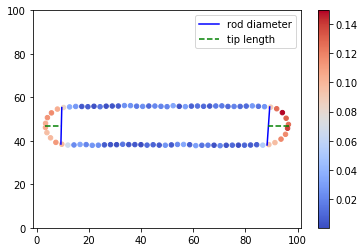

0.11905000000000002 0.106475
11


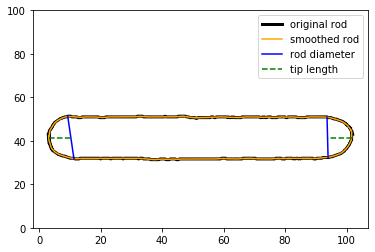

0.42764857881136936 0.3719211822660098
2116.499746365558 446.4997463655576 0.21096139847514017


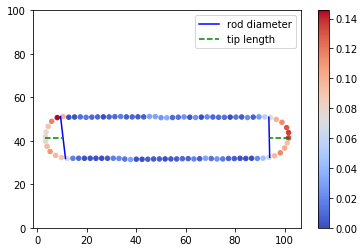

0.11006 0.0984181818181818
12


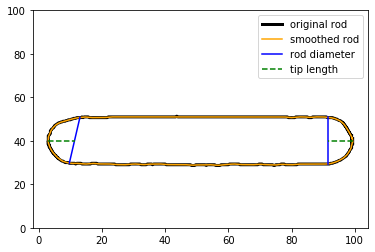

0.3593749999999996 0.398633257403189
2320.8408736169613 530.5551593312473 0.22860471192253387


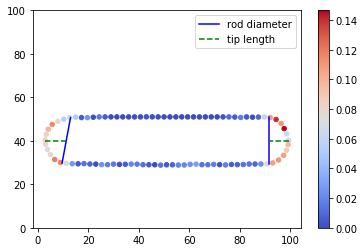

0.10411818181818182 0.08928181818181818
13


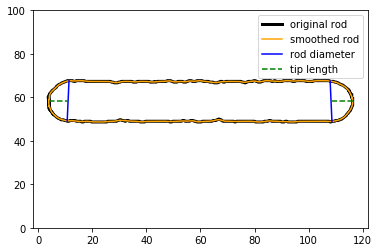

0.43076923076923024 0.3875968992248063
2289.4768755148425 440.14354218150817 0.1922463366582515


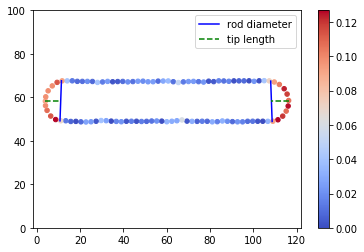

0.11187999999999998 0.10517777777777777
14


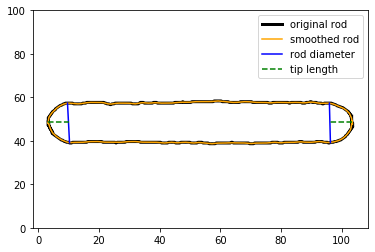

0.41248900615655215 0.3684210526315789
2095.147552260458 400.5364411493463 0.19117338094742153


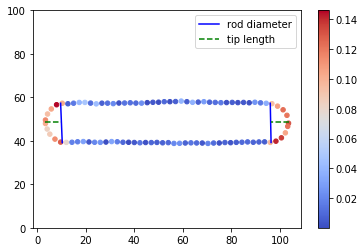

0.12027777777777778 0.10834444444444445
15


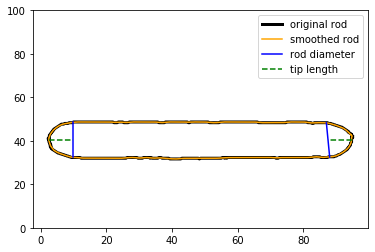

0.46656534954407286 0.46312684365781703
1686.955926527522 369.45592652752225 0.21900745639989588


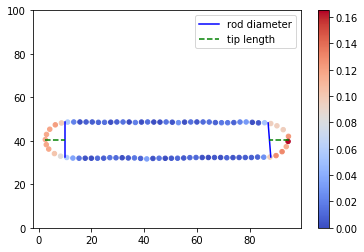

0.11671111111111111 0.11046666666666666
16


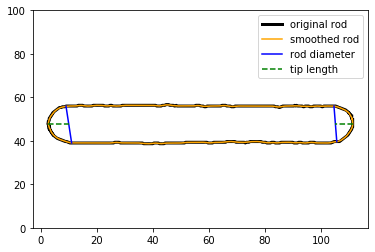

0.3786549707602332 0.4334277620396599
2049.5320574405555 350.127295535793 0.17083279779142857


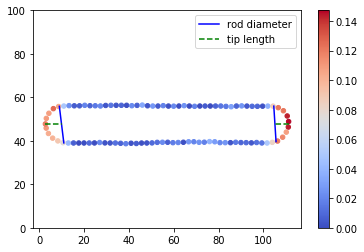

0.1280625 0.1083
17


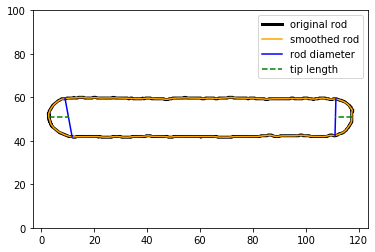

0.3764204545454553 0.42547425474254735
2221.08930676173 372.4781956506188 0.1677006838566428


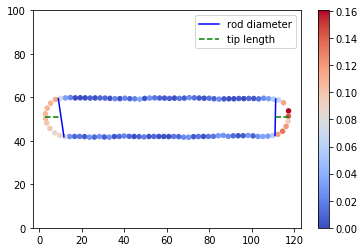

0.1189625 0.1
18


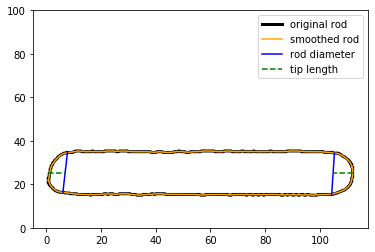

0.3771929824561406 0.3363636363636364
2384.1440178889948 391.47735122232825 0.16420037895569586


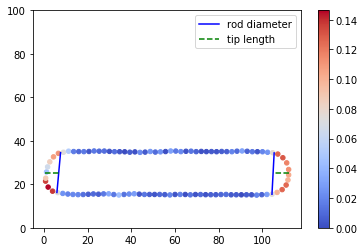

0.11577777777777779 0.09998
19


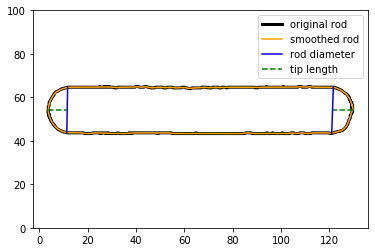

0.3959276018099539 0.3781609195402296
2894.4248390753082 530.393093043562 0.1832464556975708


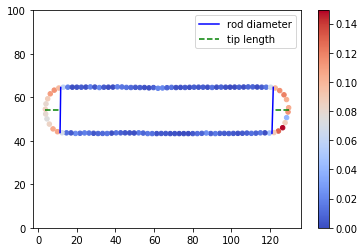

0.10516363636363636 0.09374545454545456


In [293]:
to_skip = [124, 114, 108, 104, 100, 75, 44, 41, 36, 32, 8, 4]

for i in range(0,20):
    print(i)
    image = data['particles_plot'][0][i]
    rotated = ndimage.rotate(image, 360-data['orientation_plot'][0][i][0][0])
    ratio_extracted = determine_curvature(rotated)
    
# change parameters of curvature calculation and see if it changes points